BiLSTM Model Tests
===

## 1. Importing Dependencies

In [1]:
#import files
import sys
from csv import reader
from typing import List
from nltk.tokenize import RegexpTokenizer
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
import numpy as np
import inflect
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras.backend as K
import optuna
from matplotlib.pyplot import figure

## 2. Initial Setup - Defining the driving variables, dataset to parse

In [2]:
# Determines which dataset use and how much to use :
# HateSpeech: Column-0 : Sentence, Column-1 : Label [noHate-0, Hate-1]
# either 'HateSpeech' or 'KaggleTwitter' or 'TDavidson'
dataset_to_use = "HateSpeech"
dataset_percentage = 100  # percentage range 1 to 100

# Initializes file path, column of csv file to parse and
# the delimiter for parsing
training_file = ""
test_file = ""
sentence_column_to_parse = None
label_column_to_parse = None
lancaster = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
delimiter = ","
if dataset_to_use == "HateSpeech":
    training_file = "datasets/hate-speech/train.txt"
    test_file = "datasets/hate-speech/test.txt"
    delimiter = "\t"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
elif dataset_to_use == "KaggleTwitter":
    training_file = "datasets/kaggle-twitter/newtrain.csv"
    test_file = "datasets/kaggle-twitter/newtest.csv"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
elif dataset_to_use == "TDavidson":
    training_file = "datasets/t-davidson-hate-speech/train.csv"
    testing_file = "datasets/t-davidson-hate-speech/test.csv"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
else:
    print("Invalid Dataset specified")
    sys.exit(1)

## 3. Parsing the data

In [3]:
def parse_data(training_file_path: str, percentage: int,
               sentence_column: int, label_column: int,
               delimit: str):
    """This function is used to parse input lines
    and returns a the provided percent of data.

    Args:
        lines (List[str]): list of lines
        percentage (int): percent of the dataset needed
        sentence_column (int): sentence column from the dataset
        label_column (int): label column from the dataset
        delimit (str): delimiter
    Returns:
        List[str], List[str]: examples , labels -> [percentage of dataset]
    """
    percentage_sentences = []
    percentage_labels = []
    with open(training_file_path, "r", encoding="utf8",
              errors="ignore") as csvfile:
        read_sentences = []
        label_sentences = []
        csv_reader = reader(csvfile, delimiter=delimit)
        # skipping header
        header = next(csv_reader)
        # line_length = len(list(csv_reader_copy))
        if header is not None:
            for row in csv_reader:
                read_sentences.append(row[sentence_column])
                label_sentences.append(int(row[label_column]))
        end_of_data = int(len(read_sentences) * percentage * .01)
        percentage_sentences = read_sentences[0:end_of_data]
        percentage_labels = label_sentences[0:end_of_data]
    return percentage_sentences, percentage_labels

In [4]:
train_sentences, train_labels = parse_data(training_file,
                                           dataset_percentage,
                                           sentence_column_to_parse,
                                           label_column_to_parse,
                                           delimiter)

test_sentences, test_labels = parse_data(
    test_file, dataset_percentage,
    sentence_column_to_parse,
    label_column_to_parse, delimiter)

## 4. Preprocessing the Data

### Five tasks are done as part of this:
  - lower word case
  - remove stopwords
  - remove punctuation
  - convert numbers to texts
  - perform stemming


In [5]:
def replace_numbers(sentence:List[str]) -> List[str]:
    """Replace all interger occurrences in list of tokenized words
    with textual representation"""
    p = inflect.engine()
    new_words = []  
    for word in sentence.split():
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return " ".join(new_words)

def stem_words(sentence: List[str]) -> List[str]:
    """Stems the given sentence

    Args:
        sentence (list): words to be stemmed

    Returns:
        str: stemmed sentence
    """
    stemmed_words = []
    for word in sentence.split():
        stemmed_words.append(lancaster.stem(word))
    return " ".join(stemmed_words)

def preprocessing(running_lines: List[str]) -> List[str]:
    """This function takes in the running test and return back the
    preprocessed text. Six tasks are done as part of this:
      1. lower word case
      2. remove stopwords
      3. remove punctuation
      4. convert numbers to texts
      5. perform stemming

    Args:
        sentence (List[str]): list of lines

    Returns:
        List[str]: list of sentences which are processed
    """
    preprocessed_lines = []
    tokenizer = RegexpTokenizer(r"\w+")
    for line in running_lines:
        # lower case
        lower_case_data = line.lower()
        # remove stop words
        data_without_stop_word = remove_stopwords(lower_case_data)
        # remove punctunation
        data_without_punct = strip_punctuation(data_without_stop_word)
        # replace numbers '1' to 'one'
        processed_data = replace_numbers(data_without_punct)
        # stem words
        processed_data = stem_words(processed_data)
        # add start and stop tags
        # processed_data.insert(0, "<s>")
        # processed_data.append("</s>")
        preprocessed_lines.append(processed_data)
    return preprocessed_lines

In [6]:
processed_train_sentences = preprocessing(train_sentences)

processed_test_sentences = preprocessing(test_sentences)

print(
    f"Performing Improved - BiLSTM on {dataset_to_use}"
    f" with {dataset_percentage} % data ")

Performing Improved - BiLSTM on HateSpeech with 100 % data 


## 5. Building Model

### 5.1 Generating word embeddings

For this step, we intend to use the Keras library to build a recurrent neural network based on bidirectional LSTMs. The model will take word embeddings as input so we will use pre-trained GloVe embeddings to make the embedding dictionary.

In [7]:
def convert_sentence_word_embeddings(X_train_sentences:List[str]):
    """Converts the sentences into word embeddings.

    Args:
        X_train_sentences (List[str]): list of training sentences

    Returns:
        tuple: word embeddings for each sentence, vocab size and embedding dictionary
    """
    tokenizer = Tokenizer()
    text = np.array(X_train_sentences)
    tokenizer.fit_on_texts(X_train_sentences)
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    embeddings_dict = {}
    file_embeddings = open("utils/glove.twitter.27B.50d.txt", encoding="utf8")
    for embedding_line in file_embeddings:
        values = embedding_line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
    file_embeddings.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (text, word_index, embeddings_dict)

In [8]:
processed_sentences = processed_train_sentences + processed_test_sentences
all_labels = train_labels + test_labels

X_train_Glove_s, word_index_s, embeddings_dict_s = convert_sentence_word_embeddings(processed_sentences)

embedding_size = len(X_train_Glove_s[0])

print(len(word_index_s))

Found 4487 unique tokens.
Total 1193514 word vectors.
4487


### 5.2 Define metric functions

In [9]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def get_precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def get_recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

### 5.3 Function to create BiLSTM model with given hyperparameters

In [10]:
def build_bilstm(
    word_index, 
    embeddings_dict,   
    embedding_dim,
    num_hidden_layers,
    num_nodes_per_hidden_layer,
    num_nodes_final_fc_layer,
    input_dropout,
    recurrent_dropout,
    output_dropout,
    learning_rate,
    max_sequence_length, 
    nclasses=2
    ):

    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " embedding_dim is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,num_hidden_layers):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(num_nodes_per_hidden_layer, return_sequences=True, recurrent_dropout=recurrent_dropout, dropout=input_dropout)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(output_dropout))
    model.add(Bidirectional(LSTM(num_nodes_per_hidden_layer, recurrent_dropout=recurrent_dropout, dropout=input_dropout)))
    model.add(Dropout(output_dropout))
    # Add the fully connected layer with relu activation
    model.add(Dense(num_nodes_final_fc_layer, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # keras.optimizers.ada
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', get_f1, get_precision, get_recall])
    return model

### 5.4 Objective Function to use when running trials, creates models with different hyperparameters

In [11]:
print("Building Model!")

# The ones we want to look at:
# 1. Number of BiLSTM layers
# 2. Number of nodes per BiLSTM layer
# 3. Learning rate
# 4. Output dropout

def objective(trial):

    model = build_bilstm(
        word_index=word_index_s, 
        embeddings_dict=embeddings_dict_s, 
        embedding_dim=50,
        num_hidden_layers=2,
        num_nodes_per_hidden_layer=32,
        num_nodes_final_fc_layer=256,
        input_dropout=0,
        recurrent_dropout=.2,
        output_dropout=.5,
        learning_rate=trial.suggest_float("lr", 1e-3, 1e-2, log=True),
        max_sequence_length=embedding_size)

    X_train, X_test, y_train, y_test = train_test_split(X_train_Glove_s, all_labels, test_size = 0.2)
    data_history = model.fit(np.array(X_train), np.array(y_train),
                           validation_data=(np.array(X_test),np.array(y_test)),
                           epochs=3,
                           batch_size=128,
                           verbose=1)

    trial.set_user_attr("loss", data_history.history['loss'])
    trial.set_user_attr("accuracy", data_history.history['accuracy'])
    trial.set_user_attr("f1", data_history.history['get_f1'])
    trial.set_user_attr("recall", data_history.history['get_recall'])
    trial.set_user_attr("precision", data_history.history['get_precision'])
    
    score = model.evaluate(np.array(X_train), np.array(y_train), verbose=0)
    return score[1]

Building Model!


### 5.5 Run Study

In [12]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-12-11 20:31:02,050] A new study created in memory with name: no-name-b28d9159-3dbe-4bd9-8a55-732c11413190


Epoch 1/3
15/15 [==============================] - 25s 982ms/step - loss: 0.6728 - accuracy: 0.6030 - get_f1: 0.6705 - get_precision: 0.5051 - get_recall: 1.0000 - val_loss: 0.6085 - val_accuracy: 0.6715 - val_get_f1: 0.6478 - val_get_precision: 0.4791 - val_get_recall: 1.0000
Epoch 2/3
15/15 [==============================] - 14s 944ms/step - loss: 0.5196 - accuracy: 0.7578 - get_f1: 0.6706 - get_precision: 0.5052 - get_recall: 1.0000 - val_loss: 0.5545 - val_accuracy: 0.7092 - val_get_f1: 0.6478 - val_get_precision: 0.4791 - val_get_recall: 1.0000
Epoch 3/3
15/15 [==============================] - 14s 939ms/step - loss: 0.3983 - accuracy: 0.8462 - get_f1: 0.6692 - get_precision: 0.5050 - get_recall: 1.0000 - val_loss: 0.5746 - val_accuracy: 0.7197 - val_get_f1: 0.6478 - val_get_precision: 0.4791 - val_get_recall: 1.0000


[I 2021-12-11 20:32:00,228] Trial 0 finished with value: 0.8985355496406555 and parameters: {'lr': 0.005997606288938299}. Best is trial 0 with value: 0.8985355496406555.


Epoch 1/3
15/15 [==============================] - 24s 1s/step - loss: 0.6791 - accuracy: 0.5549 - get_f1: 0.6641 - get_precision: 0.4979 - get_recall: 1.0000 - val_loss: 0.6354 - val_accuracy: 0.6485 - val_get_f1: 0.6747 - val_get_precision: 0.5099 - val_get_recall: 1.0000
Epoch 2/3
15/15 [==============================] - 16s 1s/step - loss: 0.6419 - accuracy: 0.6302 - get_f1: 0.6636 - get_precision: 0.4979 - get_recall: 1.0000 - val_loss: 0.5849 - val_accuracy: 0.6904 - val_get_f1: 0.6747 - val_get_precision: 0.5099 - val_get_recall: 1.0000
Epoch 3/3
15/15 [==============================] - 22s 1s/step - loss: 0.5822 - accuracy: 0.6951 - get_f1: 0.6641 - get_precision: 0.4978 - get_recall: 1.0000 - val_loss: 0.5619 - val_accuracy: 0.7155 - val_get_f1: 0.6747 - val_get_precision: 0.5099 - val_get_recall: 1.0000


[I 2021-12-11 20:33:07,694] Trial 1 finished with value: 0.741108775138855 and parameters: {'lr': 0.0017672222816129137}. Best is trial 0 with value: 0.8985355496406555.


Epoch 1/3
15/15 [==============================] - 27s 1s/step - loss: 0.6750 - accuracy: 0.5732 - get_f1: 0.6668 - get_precision: 0.5011 - get_recall: 1.0000 - val_loss: 0.6111 - val_accuracy: 0.6841 - val_get_f1: 0.6636 - val_get_precision: 0.4968 - val_get_recall: 1.0000
Epoch 2/3
15/15 [==============================] - 24s 2s/step - loss: 0.6002 - accuracy: 0.6961 - get_f1: 0.6662 - get_precision: 0.5007 - get_recall: 1.0000 - val_loss: 0.5708 - val_accuracy: 0.7197 - val_get_f1: 0.6636 - val_get_precision: 0.4968 - val_get_recall: 1.0000
Epoch 3/3
15/15 [==============================] - 23s 2s/step - loss: 0.5319 - accuracy: 0.7469 - get_f1: 0.6666 - get_precision: 0.5011 - get_recall: 1.0000 - val_loss: 0.5681 - val_accuracy: 0.7238 - val_get_f1: 0.6636 - val_get_precision: 0.4968 - val_get_recall: 1.0000


[I 2021-12-11 20:34:27,559] Trial 2 finished with value: 0.76778244972229 and parameters: {'lr': 0.002731521549405825}. Best is trial 0 with value: 0.8985355496406555.


Number of finished trials: 3
Best trial:
  Value: 0.8985355496406555
  Params: 
    lr: 0.005997606288938299


### 5.6 Plot Study Results

FrozenTrial(number=0, values=[0.8985355496406555], datetime_start=datetime.datetime(2021, 12, 11, 20, 31, 2, 52539), datetime_complete=datetime.datetime(2021, 12, 11, 20, 32, 0, 228959), params={'lr': 0.005997606288938299}, distributions={'lr': LogUniformDistribution(high=0.01, low=0.001)}, user_attrs={'loss': [0.6728318333625793, 0.5196043252944946, 0.39825257658958435], 'accuracy': [0.6030334830284119, 0.7578451633453369, 0.8462343215942383], 'f1': [0.670477032661438, 0.6705889105796814, 0.6692168712615967], 'recall': [1.0, 1.0, 1.0], 'precision': [0.5051388740539551, 0.5052083134651184, 0.5049999952316284]}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


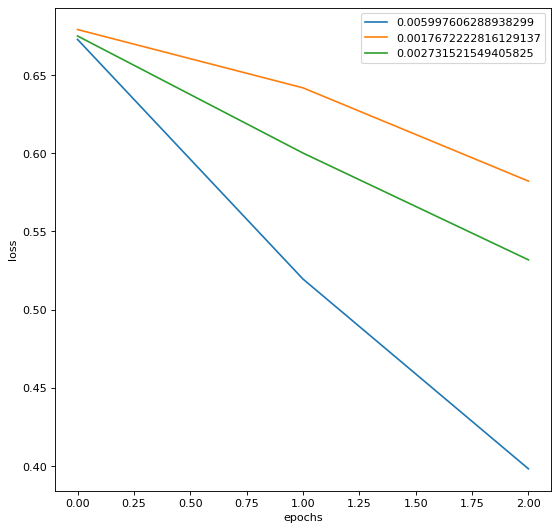

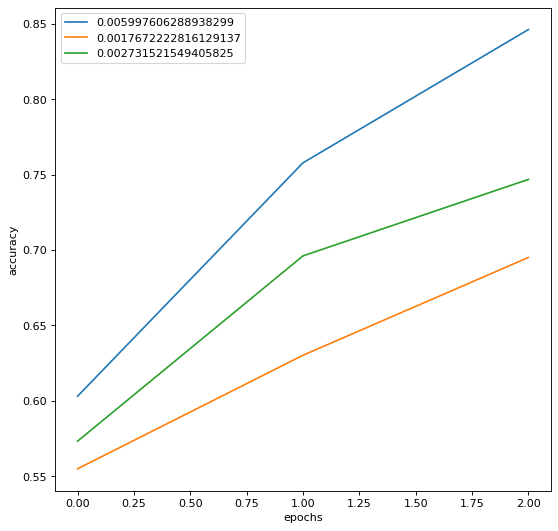

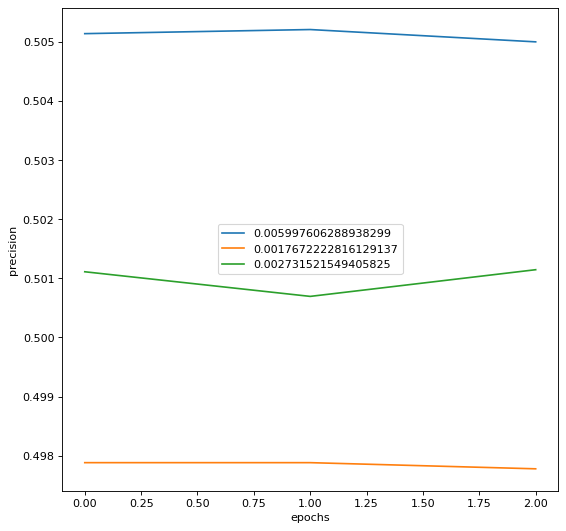

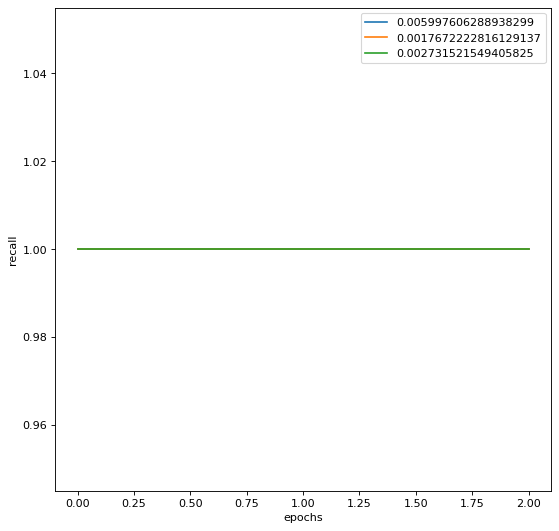

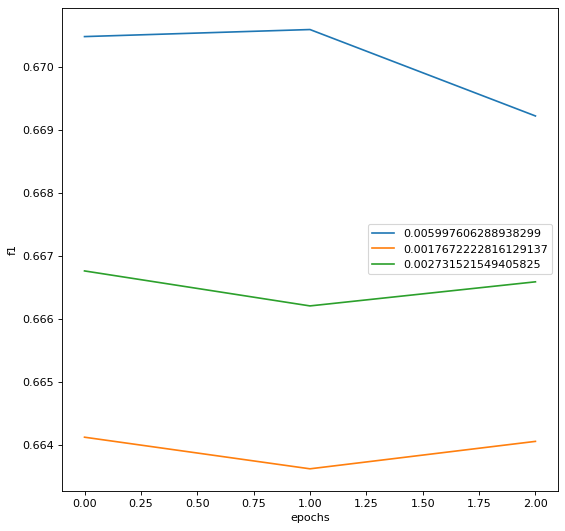

In [13]:
def plot_graphs(trials, parameter, metric):
    legends = []
    figure(figsize=(8, 8), dpi=80)
    for trial in trials:
        list_all_loss = trial.user_attrs[metric]
        legends.append(trial.params[parameter])
        plt.plot(list_all_loss)
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(legends)
    plt.savefig(metric + ".png")
    plt.show()

trials = study.get_trials()
parameter = "lr"

print(study.best_trial)

plot_graphs(trials, parameter, "loss")
plot_graphs(trials, parameter, "accuracy")
plot_graphs(trials, parameter, "precision")
plot_graphs(trials, parameter, "recall")
plot_graphs(trials, parameter, "f1")
